# Introduction

In this tutorial we will take a brief look at clustering and it's importance and then delve into one specific type: Density based clustering. We will look at its core concepts, apply it to some examples and see it's performance when compared to K-means clustering - a standard clustering algorithm. We will also attempt to qualitatively gauge when density based clustering algorithms can perform better than others.

## Content

[1. Motivation for Clustering algorithms](#clustering)  
[2. Understanding DBSCAN](#dbscan)  
[3. Comparison of DBSCAN & K-Means using blobs](#blobs)   
[4. Comparison of DBSCAN & K-Means using moons](#moons)  
[5. Conclusion](#conclusion)  
[6. References](#reference)


<a id='clustering'></a>

## 1. Motivation for Clustering algorithms:

In data science, especially machine learning, we come across two primary types of problems: Classification and Regression. A third type of problem commonly encuontered in this domain is known as **Clustering**. In this type of problem, the goal is to group data points that share similar attributes into one cluster. For this purpose we use *'clustering algorithms'* that assess the similarity of data points and ascribe or label them to different groups or *'clusters'* 

One may be tempted to think that Clustering is infact just a multi-label classification problem but there are subtle differences. Generally in a classification problem the number of classes or labels are known beforehand. This may not always be the case in clustering. One may begin with a set of data points with a hope to understand the groups involved and this is where clustering algorithms are useful.

Let us understand the differences between density based clustering and the more conventional clustering algorithms like K-means by applying these algorithms on some generated data.

In [62]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
#sns.set()
#plt.xkcd() To see funkier version of the plots below uncomment the command in this line, delete this comment and run the notebook again!!!


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Apart from the regular numpy, pandas and matplotlib modules, we also need to load two functions from the datasets library of sklearn module. These are make_blobs and make_moons. As the names suggest, these functions help make datasets that resemble blobs and moons respectively while giving the user control over the number of sample points, whether to make the data noisy or noise free and other relevant configurations.

For the clustering algorithms we specifically use the KMeans and DBSCAN algorithms from the "cluster" library of the Sklearn module. Some of the other modules are for convenience of data manipuation and seaborn is specifically for rendering of better plot images.

<a id='dbscan'></a>

## 2. Understanding DBSCAN:

To begin, we will first walk try to understand how the DBSCAN algorithm works. But before we dive in, we will first learn the concept of epsilon neighborhood or e-neighborhood.

For a given point p in a set of datapoints, the e-neighborhood of p is defined as the number of datapoints that lie within epsilon distance of that point (epsilon > 0). Let us see what this looks like.

I'm generating a bounded random dataset of 100 points along with a central point. I've then written a function to generate a boundary of epsilon distance around the test point. In a 2D space this is a circle, in 3D it would be a sphere. For an N dimensional data set this would be an N-sphere. 

In [63]:
test_point = np.array([3,2])
datapoints = 1.5*(np.random.rand(100,2)-0.5) + test_point

In [64]:
def create_boundary(t_point, epsilon = 0.5):
    surround = np.linspace(0, 2*np.pi, 100)
    neighborhood = []
    data_x, data_y = t_point
    #Create a circle of radius epsilon
    for direction in surround:
        pos_x = data_x + epsilon*np.cos(direction)
        pos_y = data_y + epsilon*np.sin(direction)
        neighborhood.append((pos_x,pos_y))
    return neighborhood

<a id='funexercise'></a>

In [65]:
neighborhood = create_boundary(test_point, epsilon = 0.30)
X,Y = zip(*neighborhood)
X,Y = np.array(X),np.array(Y)
count = len(filter(lambda x: x < 0.15, cdist(datapoints, test_point.reshape(1,2))))

Let's plot and see how the e-neighborhood space around our test point look like.

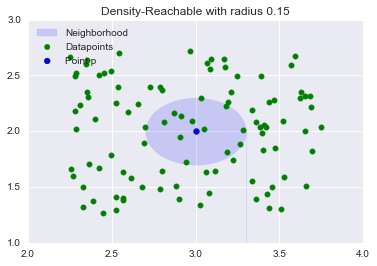

In [66]:
plt.fill_between(X, Y, alpha = 0.15, color = 'b', label = "Neighborhood")
plt.scatter(datapoints[:,0], datapoints[:,1], s = 30, color = 'g',label = "Datapoints")
plt.scatter(test_point[0],test_point[1], s = 35, label = "Point p")
plt.xlim(2,4)
plt.ylim(1,3)
plt.legend(loc = 2)
plt.title("Density-Reachable with radius 0.15")

#### Fun exercise

Try different sizes of epsilon and see the change in the e-neighborhood of point p. Change the value of epsilon [here](#funexercise) and re-run the jupyter cells upto the diagram above. Count the number of points in the blue shaded area to find out the e-neighborhood. Do you realize something?

Lesson: It is possible that by changing epsilon by a small value, you get a large or small change in e-neighborhood value. This totally depends on the density and distribution of the dataset.

The DBSCAN algorithm takes advantage of this very density distribution to cluster together the points that have similar densities.

The DBCAN algorithm takes two input, epsilon(e) and minimum points(m). Based on these two inputs, the algorithm creates three types of points - Core points, Border points and outliers.

Core points: Points which have atleast m points in its e-neighborhood  
Boundary points: Points which have less then m points in its e-neighborhood  
Outliers: All other points

#### Algorithm:  
1. Start by selecting a random point that has not been assigned to a label. Calculate its e-neighborhood to find out if it’s a core point. If yes, then start clustering around this point. If no, then label this point as an outlier.

2. The moment we find a core point and therefore a cluster, add all directly-reachable points to the cluster. Use the same process on each of the other points in the cluster to find all density-reachable points and add them to the cluster as well. If you come across an outlier during this step, it means this is a border point. Change it's status to reflect the same.

3. Repeat steps 1 & 2 until all points are either assigned a label or designated as an outlier.

<a id='blobs'></a>

## 3. Comparison of DBSCAN & K-Means using blobs

The **make_blobs** function is part of the datasets library in the Sklearn module to generate globular clusters of data. The website defines this function as "generating isotropic gaussian blobs for clustering". To generate these, we need to pass values into the function parameters which include number of datapoints generated, number of input features for each datapoint, number of cluster centres and their standard deviations as well as possible upper and lower bound on the occurence of these cluster centers.

The output of the make_blobs function is the data points (n_samples,n_features) and their respective labels conveying cluster membership.

In the cell below, we've defined 3 centres (1.5, 1.5), (-1.5, -1.5), (1.5, -1.5) and then called the make_blobs function with 1200 sample points and a standard deviation of 0.5

Before we apply DBSCAN and KMeans on this data we are going to be doing one additional step on the data. For this we use the StandardScaler function from the preprocessing library from the Sklearn module. This function simply transforms the data by subtracting the mean from each feature and scaling to unit variance.

In [67]:
centers = [[1.5, 1.5], [-1.5, -1.5], [1.5, -1.5]]
blob_datapoints, blob_labels = make_blobs(n_samples=1200, centers=centers, cluster_std=0.5,random_state=0)
blob_datapoints = StandardScaler().fit_transform(blob_datapoints)

In the cell below we are creating an object of class DBSCAN with a epsilon value of 0.3 and min_samples of 10. We then extract the labels and define the number of clusters based on the same.

In [68]:
db_object = DBSCAN(eps=0.3, min_samples=10).fit(blob_datapoints)
core_mask = np.zeros_like(db_object.labels_, dtype=bool)
core_mask[db_object.core_sample_indices_] = True
blob_labels = db_object.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(blob_labels)) - (1 if -1 in blob_labels else 0)

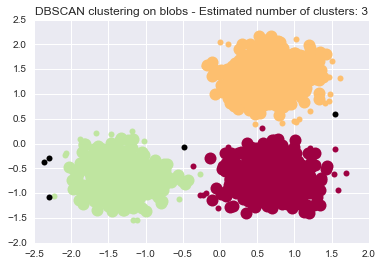

In [69]:
labels_unique = set(blob_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(labels_unique)))
for m, col in zip(labels_unique, colors):
    if m == -1:
     
        col = 'k'

    c_mask = (blob_labels == m)

    xy =blob_datapoints[c_mask & core_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=12)

    xy = blob_datapoints[c_mask & ~core_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN clustering on blobs - Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [70]:
km_object = KMeans(n_clusters = 3).fit(blob_datapoints)
labels = km_object.labels_
labels_unique = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(labels_unique)))

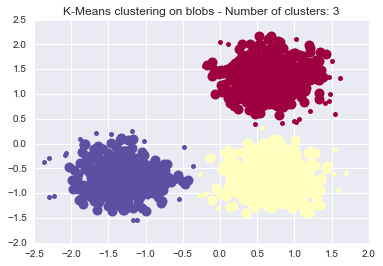

In [71]:
for (label, color) in zip(labels_unique, colors):
    class_member_mask = (labels == label)
    xy = blob_datapoints[class_member_mask & core_mask]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = blob_datapoints[class_member_mask & ~core_mask]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("K-Means clustering on blobs - Number of clusters: %d" % n_clusters_)

<a id='moons'></a>

## 4. Comparison of DBSCAN & K-Means using moons

The make_moons function takes in number of samples as input and generates data points that make a moon like shape in a 2-D coordinate space.Specifically it generates as the website defines it "two interleaving half circles". The function also outputs labels for each data point such that all points from a particular half moon will have the same label. We are using such data points to gauge the effectiveness of our chosen clustering algorithms in correctly labelling the data. 

In [72]:
moons_datapoints, moons_labels = make_moons(n_samples = 2000)

The data generated by the make_moons algorithm is rather neatly structured (perfect half moons) and does not represent data in the real world. To make this exercise slightly more realistic, we will add some noise to the data points that we generated in the cell above. This will also help reveal some aspects about DBSCAN which will be discussed later.

In [73]:
def add_noise(X,y, noise_level = 0.01):
    #The number of points we wish to make noisy
    amt_noise = int(noise_level*len(y))
    #Pick amt_noise points at random
    idx = np.random.choice(len(X), size = amt_noise)
    #Add random noise to these selected points
    noise = np.random.random((amt_noise, 2) ) -0.5
    X[idx,:] += noise
    return X

Now that we have defined our noise function we can apply it to the generated datapoints and finally visualize how this data looks like with its respective labels.

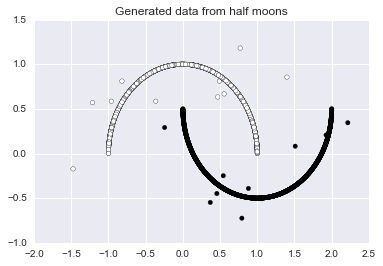

In [74]:
moons_noisydata = add_noise(moons_datapoints, moons_labels)
plt.scatter(moons_noisydata[:,0], moons_noisydata[:,1], c = moons_labels)
plt.title("Generated data from half moons")

Now that we have our datapoints and associated labels (white and black), we can try DBSCAN & KMeans and see how each of these algorithms classify the given datapoints. In the cell below, I've created a object of class DBSCAN and given it's configuration parameters (epsilon and min_samples) some predefined values. Further, we fit the data we have to this DBSCAN object and extract the resultant labels and core samples.

In [75]:
db_object = DBSCAN(eps = 0.05, min_samples = 10).fit(moons_noisydata)
#Get the cluster labels
labels = db_object.labels_
#Identify the core and border points
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[db_object.core_sample_indices_] = True

Next we find the unique set of labels and give them colors which will help us identify and visualize how the algorithm has clustered the given set of datapoints. When plotting, we plot the two cluster labels as well as the outlier's which do not belong to any particular labelled category. Note that in this case the red points are the outliers.

In [76]:
labels_unique = np.unique(labels)
colors = ["red", "gold", "silver"]

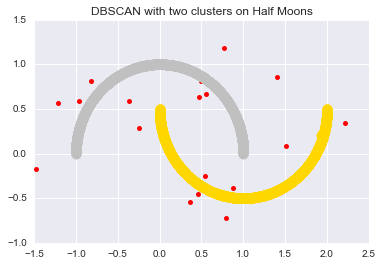

In [77]:
for (label, color) in zip(labels_unique, colors):
    class_member_mask = (labels == label)
    xy = moons_noisydata[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = moons_noisydata[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN with two clusters on Half Moons")

Just like we did for DBCAN, we repeat the procedure with K-Means to see the clustering result. Again, we create a object, this time of KMeans class. An important distinction in the way the two algorithms are setup : In DBSCAN we did not need to specify the number of clusters to be formed. The principle of the algorithm is such that based on density and epsilon neighborhood concept, it figures out the optimal number of clusters in the data, whereas in KMeans one is explicitly required to configure the desired number of clusters they want. In such a case, one should either know before hand how many clusters are supposed to exist in the dataset or attempt to run the algorithm multiple times with different number of cluster configuration values and based on context determine which one is the most feasible answer.  
In the example below, since we are aware there are two labels, we configure the n_clusters parameter to be equal to 2. After that, just like the previous case we extract the label after the algorithm has been fitted to the given data. We find the set of unique label, assign them colors and plot the datapoints in the color of their respective label as assigned by the algorithm.

In [78]:
km_object = KMeans(n_clusters = 2).fit(moons_noisydata)
labels = km_object.labels_
labels_unique = np.unique(labels)
colors = ["gold", "silver"]

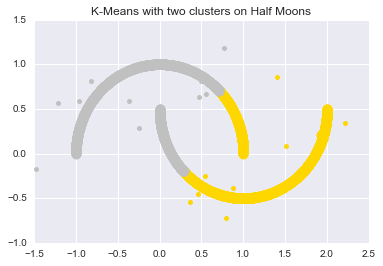

In [79]:
for (label, color) in zip(labels_unique, colors):
    class_member_mask = (labels == label)
    xy = moons_noisydata[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = moons_noisydata[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("K-Means with two clusters on Half Moons")

<a id='conclusion'></a>

## 5. Conclusion:

We can clearly see the difference in the outputs of the two algorithms on the two datasets. KMean's is a clustering algorithm that can only give globular or spherical clusters (circular in a 2-D sense). Therefore the hlaf moons dataset has been segragated based on distance from the final centroids selected and clearly no consideration has been given to the shape that the datapoints are creating. Conversely in DBSCAN, owing to the density and e-neighborhood relationship, the data points in each half moon get clustered or categorized with the same label.

Another difference we see in the way the algorithms outputs have played out is that DBSCAN does not necessarily put all data points in a cluster. If a point does not qualify the e-neighborhood- core or boundary point criteria it can be considered an outlier whereas KMeans necessarily will put all data points in one of the given number of clusters. This can clearly be seen in the blobs dataset where DBSCAN tags some of the points far away from all clusters as outliers. Also in the half moons dataset we see that even the noisy datapoints have been categorized by K-Means into one label or another whereas DBSCAN simply labelled them as outliers (in red).

In conclusion, we realize that DBSCAN utilizes the underlying density distribution for clustering and will work better in the datasets which have strong patterns. Additionally one need not define the number of clusters present as the algorithm will figure it out on its own. Lastly, DBSCAN does not necessarily classify all points into one or the other category and may create outliers and therefore can also be used for "anomaly detection".

<a id='reference'></a>

## 6. References:

* Harris, Naftali. "Visualizing DBSCAN Clustering." https://www.naftaliharris.com . N.p., n.d. Web. 31 Oct. 2016.

* Gao, Jing. "Clustering: Density Based Methods." (n.d.): n. pag. Web. <http://www.cse.buffalo.edu/~jing/cse601/fa12/materials/clustering_density.pdf>.

* "Demo of DBSCAN Clustering Algorithm." Scikit Learn. N.p., n.d. Web. 31 Oct. 2016. <http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html>.